##### 1 – Imports

In [2]:
from sqw.tesselations import even_cycle_two_tesselation
from sqw.experiments_expanded import running
from sqw.states import uniform_initial_state, amp2prob
from sqw.statistics import states2mean, states2std, states2ipr, states2survival
from sqw.plots import final_distribution_plot, mean_plot, std_plot, ipr_plot, survival_plot
from sqw.utils import random_tesselation_order, random_angle_deviation, tesselation_choice
from jaime_scripts import save_array_list_to_file,load_array_list_from_file


import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

import tqdm

##### 2 – Dynamics

###### 2.1 – Original

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(final_dist, N, steps, y_ticks_step=2, x_ticks_step=5, ratio=0.5, cmap='viridis', cbar_label='Probability', interpolation='None', xlabel='x', ylabel='steps', xtick_labelsize=11, ytick_labelsize=11, cbar_labelpad=20, cbar_fraction=0.035, cbar_pad=0.04, fig_dpi=300, save_path=None):
    """
    Plots a 2D distribution with customizable settings.

    Parameters:
    - final_dist: 2D array, the data to plot.
    - N: int, range for x-axis (from -N//2 to N//2).
    - steps: int, range for y-axis (from 0 to steps).
    - y_ticks_step: int, step size for y-axis ticks.
    - x_ticks_step: int, step size for x-axis ticks.
    - ratio: float, aspect ratio adjustment.
    - cmap: str, colormap to use for the plot.
    - cbar_label: str, label for the color bar.
    - interpolation: str, interpolation method for imshow.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - xtick_labelsize: int, label size for x-axis ticks.
    - ytick_labelsize: int, label size for y-axis ticks.
    - cbar_labelpad: int, padding for the color bar label.
    - cbar_fraction: float, fraction of the color bar size.
    - cbar_pad: float, padding between the plot and the color bar.
    - fig_dpi: int, resolution of the figure.
    - save_path: str, path to save the figure. If None, the figure is not saved.
    """
    
    x = np.arange(-N//2, N//2, 1)
    y = np.arange(0, steps, 1)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()

    im = ax.imshow(final_dist, interpolation=interpolation, cmap=cmap, extent=[-N//2, N//2, steps, 0])

    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=xtick_labelsize)

    ax.set_xlim([-N//2, N//2])

    ax.set_yticks(np.arange(0, steps+1, y_ticks_step))
    ax.set_xticks(np.arange(-N//2, N//2 + 1, x_ticks_step))

    cbar = fig.colorbar(im, fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label(cbar_label, rotation=270, labelpad=cbar_labelpad, fontsize=14)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=fig_dpi)

    plt.show()

# Example usage
# plot_distribution(final_dist, N=50, steps=20)


In [4]:
def calculate_average_distributions(N, T, G, samples, steps,deviation):
    """
    Calculates the average distributions over a given number of samples.

    Parameters:
    - N: int, the size parameter.
    - T: object, the tesselation object.
    - G: graph, the networkx graph.
    - samples: int, the number of samples to generate.
    - steps: int, the number of steps for the process.

    Returns:
    - average_distributions: list of numpy arrays, the averaged distributions.
    """
    final_dist_list = []

    for _ in tqdm.tqdm(range(samples)):
        angles = random_angle_deviation([np.pi/3, np.pi/3], [deviation, deviation], steps)
        tesselation_order = [[0, 1] for _ in range(steps)]
        initial_state = uniform_initial_state(N, nodes=[N//2 + 1])
        
        states_ua_ut = running(G, T, steps, 
                               initial_state, 
                               angles=angles, 
                               tesselation_order=tesselation_order)

        final_dist = [amp2prob(x) for x in states_ua_ut]
        final_dist_list.append(final_dist)

    average_distributions = [np.mean(np.array(list(map(lambda x: x[i], final_dist_list))), axis=0) for i in range(len(final_dist_list[0]))]
    
    return average_distributions

def calculate_average_stdev(N, T, G, samples, steps,deviation,domain):
    """
    Calculates the average distributions over a given number of samples.

    Parameters:
    - N: int, the size parameter.
    - T: object, the tesselation object.
    - G: graph, the networkx graph.
    - samples: int, the number of samples to generate.
    - steps: int, the number of steps for the process.

    Returns:
    - average_distributions: list of numpy arrays, the averaged distributions.
    """
    final_dist_list = []

    for _ in tqdm.tqdm(range(samples)):
        angles = random_angle_deviation([np.pi/3, np.pi/3], [deviation, deviation], steps)
        tesselation_order = [[0, 1] for _ in range(steps)]
        initial_state = uniform_initial_state(N, nodes=[N//2 + 1])
        
        states_ua_ut = running(G, T, steps, 
                               initial_state, 
                               angles=angles, 
                               tesselation_order=tesselation_order)

        # final_dist = [states2std(x,domain) for x in states_ua_ut]
        final_dist = states2std(states_ua_ut,domain)
        final_dist_list.append(final_dist)

    average_distributions = [np.mean(np.array(list(map(lambda x: x[i], final_dist_list))), axis=0) for i in range(len(final_dist_list[0]))]
    
    return average_distributions

File exists!


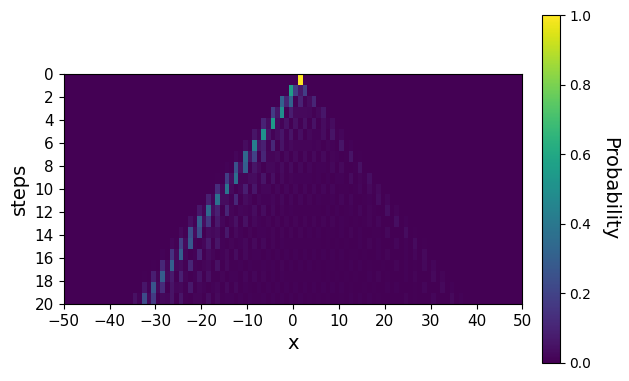

In [5]:
# Example usage
N = 100
T = even_cycle_two_tesselation(N)
G = nx.cycle_graph(N)
samples = 100
steps = 20
deviation = 0

fileName = f'Datasets/Jaime-simple_dynamics/sqw_Deviation-{deviation}-_N{N}_Steps{steps}_Samples{samples}.txt'

if os.path.exists(fileName):
    average_distributions = load_array_list_from_file(fileName)
    print('File exists!')
    
else:
    average_distributions = calculate_average_distributions(N, T, G, samples, steps,deviation)
    save_array_list_to_file(average_distributions,fileName)
    print('File Doesnt Exist!')

# print(average_distributions)
plot_distribution(average_distributions, N=N, steps=steps,x_ticks_step=10)

File exists!
21


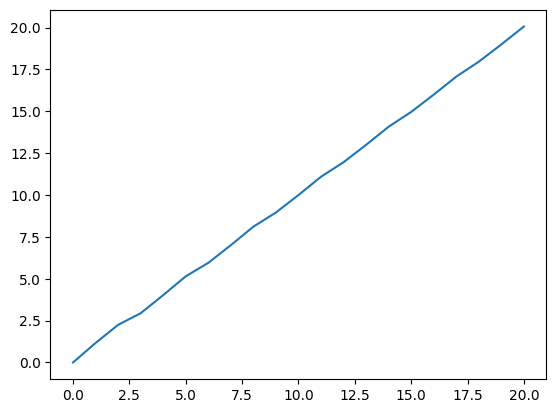

In [6]:
# Example usage
N = 100
T = even_cycle_two_tesselation(N)
G = nx.cycle_graph(N)
samples = 100
steps = 20
deviation = 0

fileName = f'Datasets/Jaime-simple_dynamics/sqwStdev_Deviation-{deviation}-_N{N}_Steps{steps}_Samples{samples}.txt'

if os.path.exists(fileName):
    average_stdev = load_array_list_from_file(fileName)
    print('File exists!')
    
else:
    average_stdev = calculate_average_stdev(N, T, G, samples, steps,deviation,range(0, N))
    save_array_list_to_file(average_stdev,fileName)
    print('File Doesnt Exist!')

# print(average_distributions)
# plot_distribution(average_stdev, N=N, steps=steps,x_ticks_step=10)
print(len(average_stdev))
plt.plot(average_stdev)

In [12]:
# x = np.arange(-N//2, N//2, 1)
# y = np.arange(0, steps, 1)
# X, Y = np.meshgrid(x, y)

# fig, ax = plt.subplots()

# im = ax.imshow(average_distributions,interpolation='None',cmap='viridis', extent = [-N//2, N//2, steps, 0])

# ratio = 0.5
# x_left, x_right = ax.get_xlim()
# y_low, y_high = ax.get_ylim()
# ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# ax.set_xlabel('x',fontsize = 14)
# ax.set_ylabel('steps',fontsize = 14)
# ax.tick_params(axis='both', which='major', labelsize=11)

# ax.set_xlim([-40,40])

# ax.set_yticks(np.arange(0, steps+1, 2))
# ax.set_xticks(np.arange(-40, 41, 10))

# cbar = fig.colorbar(im,fraction=0.035, pad=0.04)
# cbar.set_label('Probability', rotation=270,labelpad=20,fontsize = 14)


# # plt.savefig(f'images/sqw_N{N}_t{steps}_thetapi3-pi3_init0.png',bbox_inches='tight',dpi=300)
# plt.show()

In [8]:
# states2std(states_ra_ut, range(0, N))

###### 2.2 – Random Angles

100%|██████████| 50/50 [00:01<00:00, 40.16it/s]


File Doesnt Exist!


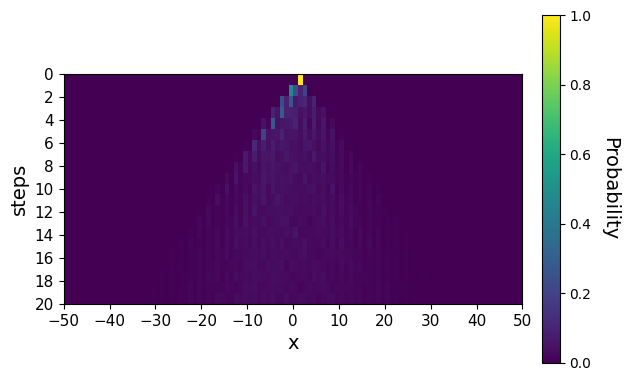

In [24]:
# Example usage
N = 100
T = even_cycle_two_tesselation(N)
G = nx.cycle_graph(N)
samples = 50
steps = 20
deviation = 0.6

fileName = f'Datasets/Jaime-simple_dynamics/sqw_Deviation-{deviation}-_N{N}_Steps{steps}_Samples{samples}.txt'

if os.path.exists(fileName):
    average_distributions = load_array_list_from_file(fileName)
    print('File exists!')
    
else:
    average_distributions = calculate_average_distributions(N, T, G, samples, steps,deviation)
    save_array_list_to_file(average_distributions,fileName)
    print('File Doesnt Exist!')

# print(average_distributions)
plot_distribution(average_distributions, N=N, steps=steps,x_ticks_step=10)

In [8]:
-

File exists!
[array([0.]), array([1.0492668]), array([2.07690441]), array([2.94123371]), array([3.95805133]), array([5.02676237]), array([5.9890621]), array([6.96440358]), array([7.96917009]), array([8.85995369]), array([9.72449055]), array([10.59547852]), array([11.4209679]), array([12.21134247]), array([13.00229699]), array([13.74699203]), array([14.51667919]), array([15.24960268]), array([15.96156685]), array([16.7057464]), array([17.37013765])]


In [23]:
# x = np.arange(-N//2, N//2, 1)
# y = np.arange(0, steps, 1)
# X, Y = np.meshgrid(x, y)

# fig, ax = plt.subplots()

# im = ax.imshow(final_dist,interpolation='None',cmap='viridis', extent = [-N//2, N//2, steps, 0])

# ratio = 0.5
# x_left, x_right = ax.get_xlim()
# y_low, y_high = ax.get_ylim()
# ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# ax.set_xlabel('x',fontsize = 14)
# ax.set_ylabel('steps',fontsize = 14)
# ax.tick_params(axis='both', which='major', labelsize=11)

# ax.set_xlim([-25,25])

# ax.set_yticks(np.arange(0, steps+1, 2))
# ax.set_xticks(np.arange(-20, 21, 5))

# cbar = fig.colorbar(im,fraction=0.035, pad=0.04)
# cbar.set_label('Probability', rotation=270,labelpad=20,fontsize = 14)


# # plt.savefig(f'images/sqw_N{N}_t{steps}_thetapi3-pi3_init0.png',bbox_inches='tight',dpi=300)
# plt.show()